In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

In [2]:
e1 = 1.0
e2 = 4.0
v = 0.5
omega = 2.0
omega0 = e2 - e1
alpha = omega - omega0
omegaR = 0.5*jnp.sqrt((omega-omega0)**2 + jnp.abs(v)**2)

# Rabi oscillation with rotating wave approximation
def ham(t):
    return jnp.array([[e1, v/2*jnp.exp(1j*omega*t)],[jnp.conj(v)/2*jnp.exp(-1j*omega*t), e2]], dtype=jnp.complex128)

# compute the W matrix
def Wmat(t):
    return 1/jnp.sqrt(2)*jnp.array([[-jnp.exp(1j*alpha*t)*jnp.sqrt(v/v.conj()), jnp.exp(1j*alpha*t)*jnp.sqrt(v/v.conj())],
                                    [1, 1]])

# compute exact solution psi(t) given initial condition psi(0) = psi0
def exactpsi(t, psi0):
    c = jnp.cos(omegaR*t)
    s = jnp.sin(omegaR*t)
    e = jnp.exp(1j*alpha*t/2.0)
    p11 = e*(c - (1j*alpha/(2*omegaR))*s)
    p12 = -1j*e*(v/(2*omegaR))*s
    p21 = -1j*jnp.conj(e)*(jnp.conj(v)/(2*omegaR))*s
    p22 = jnp.conj(p11)
    # form unitary propagator for c(t) system
    prop = jnp.array([[p11, p12],[p21, p22]], dtype=jnp.complex128)
    # this thing gives the coefficients at time t
    ct = prop @ psi0
    # now convert back to wave function using propagator for "v=0" time-independent system
    zeroprop = jnp.diag(jnp.array([jnp.exp(-1j*e1*t), jnp.exp(-1j*e2*t)]))
    return zeroprop @ ct

In [4]:
# for differentiation purposes
def riexactpsi(t, psi0):
    psit = exactpsi(t, psi0)
    return jnp.stack([jnp.real(psit), jnp.imag(psit)])

# check, using automatic differentiation and centered differencing,
# whether LHS and RHS of Schrodinger's eqn agree!
riexactpsidot = jax.jacobian(riexactpsi, 0)
psi0 = jnp.array([1.0, 0.0])
tcheck = 0.25
seppsidot = riexactpsidot(tcheck, psi0)
lhs = 1j * (seppsidot[0] + 1j*seppsidot[1])
delta = 1e-6
lhsfd = 1j * (exactpsi(tcheck + delta, psi0) - exactpsi(tcheck - delta, psi0))/(2*delta)
rhs = ham(tcheck) @ exactpsi(tcheck, psi0)
print(lhs)
print(lhsfd)
print(rhs)

[ 0.96136619-0.26125817j -0.0086673 -0.32977711j]
[ 0.96136619-0.26125817j -0.0086673 -0.32977711j]
[ 0.96136619-0.26125817j -0.0086673 -0.32977711j]


In [5]:
# evaluate exact psi at many times
vexactpsi = jax.vmap(exactpsi, in_axes=(0, None))

In [66]:
ntvec = 200
bigT = 1.5
tvec = jnp.linspace(0, bigT, ntvec)
psit = vexactpsi(tvec, psi0)

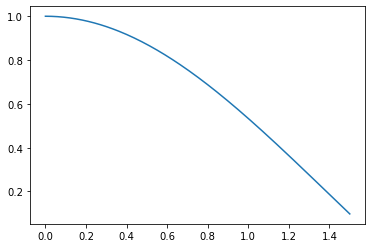

In [67]:
plt.plot(tvec, jnp.real(psit)[:,0])
plt.show()

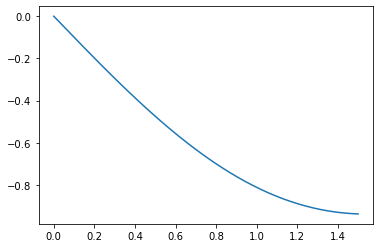

In [68]:
plt.plot(tvec, jnp.imag(psit)[:,0])
plt.show()

In [69]:
# solve the system with scipy.integrate
def schrorhs(t, y):
    return -1j*np.array(ham(t), dtype=np.complex128) @ y

sol = si.solve_ivp(schrorhs, 
                   t_span=[0, bigT], 
                   y0=np.array(psi0, dtype=np.complex128), 
                   t_eval=np.array(tvec), rtol=1e-9, atol=1e-9)

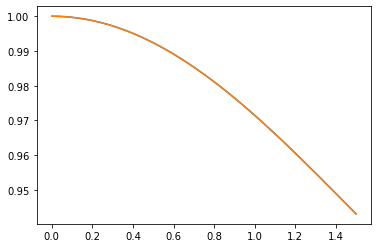

In [70]:
plt.plot(tvec, jnp.abs(psit)[:,0])
plt.plot(tvec, np.abs(sol.y.T)[:,0])
plt.show()

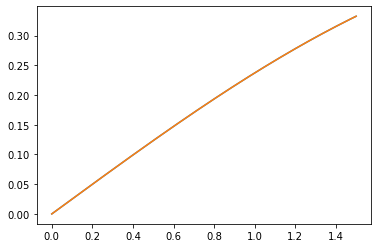

In [71]:
plt.plot(tvec, jnp.abs(psit)[:,1])
plt.plot(tvec, np.abs(sol.y.T)[:,1])
plt.show()

In [73]:
# now check our own homegrown method
ntvec = 200
dt = bigT/(ntvec-1)
mysol = [psi0]
for j in range(ntvec-1):
    spectrum, states = jnl.eigh(ham(tvec[j]))
    nextsol = states @ jnp.diag(jnp.exp(-1j*dt*spectrum)) @ states.conj().T @ mysol[-1]
    mysol.append(nextsol)

In [74]:
mysol = jnp.array(mysol)
print(mysol.shape)
print(psit.shape)

(200, 2)
(200, 2)


In [75]:
jnp.mean(jnp.abs( mysol - psit ))

DeviceArray(0.00066651, dtype=float64)

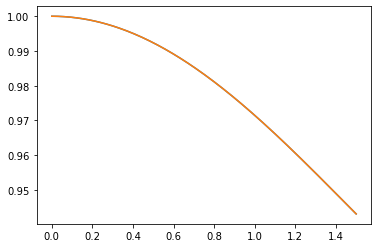

In [76]:
plt.plot(tvec, jnp.abs(psit)[:,0])
plt.plot(tvec, np.abs(mysol)[:,0])
plt.show()

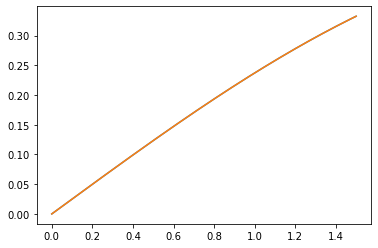

In [77]:
plt.plot(tvec, jnp.abs(psit)[:,1])
plt.plot(tvec, np.abs(mysol)[:,1])
plt.show()

In [92]:
# theta consists of Laguerre polynomial coefficients
ncoef = 20
def myloss(theta):
    thetaR = theta[:ncoef]
    thetaI = theta[ncoef:]
    # times at which we want to evaluate Laguerre polynomials
    tvec = dt*jnp.arange(ntvec-1)
    laguerre = [jnp.ones(ntvec-1), jnp.ones(ntvec-1)-tvec]
    for k in range(1, ncoef-1):
        nextlaguerre = ((2*k + 1 - tvec)*laguerre[k] - k*laguerre[k-1])/(k+1)
        laguerre.append(nextlaguerre)
    
    laguerre = jnp.array(laguerre)
    allh12 = (thetaR + 1j*thetaI) @ laguerre
    mysol = jnp.concatenate([jnp.expand_dims(psi0,0), jnp.zeros((ntvec-1, 2), dtype=jnp.complex128)])
    def onestep(j, loopsol):
        modelham = jnp.array([[e1, allh12[j]],[jnp.conj(allh12[j]), e2]])
        spectrum, states = jnl.eigh(modelham)
        nextsol = states @ jnp.diag(jnp.exp(-1j*dt*spectrum)) @ states.conj().T @ loopsol[j]
        return loopsol.at[j+1].set(nextsol)
    
    mysol = jax.lax.fori_loop(0, ntvec-1, onestep, mysol)
    resid = psit - mysol
    return 0.5*jnp.real(jnp.sum(resid * jnp.conj(resid)))

In [93]:
myloss(jnp.array(np.random.normal(size=2*ncoef)))

DeviceArray(209.85243773, dtype=float64)

In [94]:
truethetaR = jnp.array([0.05, 0.08, 0.088, 0.0768, 0.05248, 0.022528, -0.0059392, -0.0275251, 
                        -0.0392888, -0.040842, -0.0339162, -0.0215923, -0.00741469, 
                        0.00541032, 0.0145883, 0.019013, 0.0187501, 0.0147898, 0.00866364, 0.00202995])
truethetaI = -jnp.array([-0.1, -0.06, -0.016, 0.0224, 0.04864, 0.059904, 0.0569344, 0.0431718, 
                        0.0235274, 0.00310641, -0.0138517, -0.0246478, -0.0283552, -0.02565, 
                        -0.0183559, -0.0088494, 0.000525661, 0.00792058, 0.0122524, 0.0132674])
truetheta = jnp.concatenate([truethetaR, truethetaI])

In [95]:
myloss(truetheta)

DeviceArray(0.00232111, dtype=float64)

In [161]:
ntvec = 2000
tvec = dt*jnp.arange(ntvec-1)
mylaguerre = [jnp.ones(ntvec-1), jnp.ones(ntvec-1)-tvec]
for k in range(1, ncoef-1):
    nextlaguerre = ((2*k + 1 - tvec)*mylaguerre[k] - k*mylaguerre[k-1])/(k+1)
    mylaguerre.append(nextlaguerre)

mylaguerre = jnp.array(mylaguerre)
myh12 = (truethetaR + 1j*truethetaI) @ mylaguerre

In [160]:
myh12[0]

DeviceArray(0.27653482+0.00405995j, dtype=complex128)

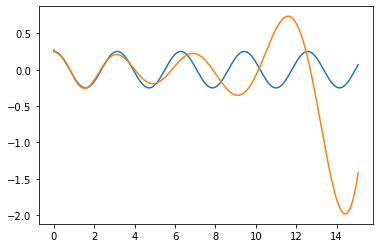

In [162]:
fintime = 2000
plt.plot(tvec[:fintime], jnp.real(v/2*jnp.exp(1j*omega*tvec))[:fintime])
plt.plot(tvec[:fintime], jnp.real(myh12)[:fintime])
plt.show()

In [99]:
gradmyloss = jax.grad(myloss)
jloss = jax.jit(myloss)
jgradloss = jax.jit(gradmyloss)

In [103]:
maxiters = 1000
lr = 1e-3
theta = jnp.array(np.random.normal(size=2*ncoef))
for ii in range(maxiters):
    thisgrad = jgradloss(theta)
    theta -= thisgrad * lr
    thisloss = jloss(theta)
    print("Iter {:d}    Loss {:6e}    ||Grad|| {:6e}".format(ii, thisloss, jnp.linalg.norm(thisgrad)))

Iter 0    Loss 3.946574e+01    ||Grad|| 6.643361e+01
Iter 1    Loss 3.611032e+01    ||Grad|| 5.947673e+01
Iter 2    Loss 3.339765e+01    ||Grad|| 5.342233e+01
Iter 3    Loss 3.118318e+01    ||Grad|| 4.820567e+01
Iter 4    Loss 2.935430e+01    ||Grad|| 4.374344e+01
Iter 5    Loss 2.782429e+01    ||Grad|| 3.994599e+01
Iter 6    Loss 2.652681e+01    ||Grad|| 3.672470e+01
Iter 7    Loss 2.541130e+01    ||Grad|| 3.399615e+01
Iter 8    Loss 2.443926e+01    ||Grad|| 3.168440e+01
Iter 9    Loss 2.358133e+01    ||Grad|| 2.972192e+01
Iter 10    Loss 2.281512e+01    ||Grad|| 2.804990e+01
Iter 11    Loss 2.212343e+01    ||Grad|| 2.661792e+01
Iter 12    Loss 2.149305e+01    ||Grad|| 2.538341e+01
Iter 13    Loss 2.091370e+01    ||Grad|| 2.431089e+01
Iter 14    Loss 2.037740e+01    ||Grad|| 2.337109e+01
Iter 15    Loss 1.987786e+01    ||Grad|| 2.254012e+01
Iter 16    Loss 1.941008e+01    ||Grad|| 2.179860e+01
Iter 17    Loss 1.897008e+01    ||Grad|| 2.113091e+01
Iter 18    Loss 1.855460e+01    ||Grad

Iter 151    Loss 5.025608e+00    ||Grad|| 5.493675e+00
Iter 152    Loss 4.995793e+00    ||Grad|| 5.466952e+00
Iter 153    Loss 4.966265e+00    ||Grad|| 5.440486e+00
Iter 154    Loss 4.937021e+00    ||Grad|| 5.414275e+00
Iter 155    Loss 4.908057e+00    ||Grad|| 5.388314e+00
Iter 156    Loss 4.879368e+00    ||Grad|| 5.362598e+00
Iter 157    Loss 4.850950e+00    ||Grad|| 5.337125e+00
Iter 158    Loss 4.822800e+00    ||Grad|| 5.311889e+00
Iter 159    Loss 4.794915e+00    ||Grad|| 5.286888e+00
Iter 160    Loss 4.767290e+00    ||Grad|| 5.262118e+00
Iter 161    Loss 4.739921e+00    ||Grad|| 5.237576e+00
Iter 162    Loss 4.712806e+00    ||Grad|| 5.213257e+00
Iter 163    Loss 4.685941e+00    ||Grad|| 5.189160e+00
Iter 164    Loss 4.659322e+00    ||Grad|| 5.165279e+00
Iter 165    Loss 4.632946e+00    ||Grad|| 5.141614e+00
Iter 166    Loss 4.606810e+00    ||Grad|| 5.118159e+00
Iter 167    Loss 4.580910e+00    ||Grad|| 5.094913e+00
Iter 168    Loss 4.555245e+00    ||Grad|| 5.071872e+00
Iter 169  

Iter 300    Loss 2.441933e+00    ||Grad|| 3.178967e+00
Iter 301    Loss 2.431897e+00    ||Grad|| 3.170106e+00
Iter 302    Loss 2.421918e+00    ||Grad|| 3.161293e+00
Iter 303    Loss 2.411993e+00    ||Grad|| 3.152530e+00
Iter 304    Loss 2.402123e+00    ||Grad|| 3.143814e+00
Iter 305    Loss 2.392307e+00    ||Grad|| 3.135145e+00
Iter 306    Loss 2.382546e+00    ||Grad|| 3.126524e+00
Iter 307    Loss 2.372837e+00    ||Grad|| 3.117949e+00
Iter 308    Loss 2.363182e+00    ||Grad|| 3.109420e+00
Iter 309    Loss 2.353579e+00    ||Grad|| 3.100936e+00
Iter 310    Loss 2.344029e+00    ||Grad|| 3.092498e+00
Iter 311    Loss 2.334530e+00    ||Grad|| 3.084104e+00
Iter 312    Loss 2.325082e+00    ||Grad|| 3.075755e+00
Iter 313    Loss 2.315686e+00    ||Grad|| 3.067449e+00
Iter 314    Loss 2.306340e+00    ||Grad|| 3.059187e+00
Iter 315    Loss 2.297044e+00    ||Grad|| 3.050967e+00
Iter 316    Loss 2.287798e+00    ||Grad|| 3.042790e+00
Iter 317    Loss 2.278601e+00    ||Grad|| 3.034655e+00
Iter 318  

Iter 449    Loss 1.388532e+00    ||Grad|| 2.217483e+00
Iter 450    Loss 1.383641e+00    ||Grad|| 2.212671e+00
Iter 451    Loss 1.378772e+00    ||Grad|| 2.207874e+00
Iter 452    Loss 1.373923e+00    ||Grad|| 2.203092e+00
Iter 453    Loss 1.369096e+00    ||Grad|| 2.198326e+00
Iter 454    Loss 1.364289e+00    ||Grad|| 2.193574e+00
Iter 455    Loss 1.359503e+00    ||Grad|| 2.188837e+00
Iter 456    Loss 1.354738e+00    ||Grad|| 2.184114e+00
Iter 457    Loss 1.349994e+00    ||Grad|| 2.179406e+00
Iter 458    Loss 1.345269e+00    ||Grad|| 2.174713e+00
Iter 459    Loss 1.340565e+00    ||Grad|| 2.170035e+00
Iter 460    Loss 1.335881e+00    ||Grad|| 2.165371e+00
Iter 461    Loss 1.331218e+00    ||Grad|| 2.160721e+00
Iter 462    Loss 1.326574e+00    ||Grad|| 2.156086e+00
Iter 463    Loss 1.321950e+00    ||Grad|| 2.151465e+00
Iter 464    Loss 1.317346e+00    ||Grad|| 2.146858e+00
Iter 465    Loss 1.312762e+00    ||Grad|| 2.142265e+00
Iter 466    Loss 1.308197e+00    ||Grad|| 2.137686e+00
Iter 467  

Iter 598    Loss 8.447978e-01    ||Grad|| 1.634609e+00
Iter 599    Loss 8.421388e-01    ||Grad|| 1.631437e+00
Iter 600    Loss 8.394901e-01    ||Grad|| 1.628272e+00
Iter 601    Loss 8.368517e-01    ||Grad|| 1.625115e+00
Iter 602    Loss 8.342235e-01    ||Grad|| 1.621966e+00
Iter 603    Loss 8.316054e-01    ||Grad|| 1.618825e+00
Iter 604    Loss 8.289975e-01    ||Grad|| 1.615692e+00
Iter 605    Loss 8.263996e-01    ||Grad|| 1.612567e+00
Iter 606    Loss 8.238118e-01    ||Grad|| 1.609450e+00
Iter 607    Loss 8.212339e-01    ||Grad|| 1.606340e+00
Iter 608    Loss 8.186661e-01    ||Grad|| 1.603238e+00
Iter 609    Loss 8.161081e-01    ||Grad|| 1.600145e+00
Iter 610    Loss 8.135599e-01    ||Grad|| 1.597059e+00
Iter 611    Loss 8.110216e-01    ||Grad|| 1.593980e+00
Iter 612    Loss 8.084930e-01    ||Grad|| 1.590909e+00
Iter 613    Loss 8.059742e-01    ||Grad|| 1.587846e+00
Iter 614    Loss 8.034651e-01    ||Grad|| 1.584791e+00
Iter 615    Loss 8.009656e-01    ||Grad|| 1.581743e+00
Iter 616  

Iter 747    Loss 5.414413e-01    ||Grad|| 1.237251e+00
Iter 748    Loss 5.399174e-01    ||Grad|| 1.235019e+00
Iter 749    Loss 5.383990e-01    ||Grad|| 1.232793e+00
Iter 750    Loss 5.368861e-01    ||Grad|| 1.230571e+00
Iter 751    Loss 5.353786e-01    ||Grad|| 1.228354e+00
Iter 752    Loss 5.338765e-01    ||Grad|| 1.226143e+00
Iter 753    Loss 5.323798e-01    ||Grad|| 1.223936e+00
Iter 754    Loss 5.308885e-01    ||Grad|| 1.221733e+00
Iter 755    Loss 5.294026e-01    ||Grad|| 1.219536e+00
Iter 756    Loss 5.279220e-01    ||Grad|| 1.217344e+00
Iter 757    Loss 5.264467e-01    ||Grad|| 1.215156e+00
Iter 758    Loss 5.249768e-01    ||Grad|| 1.212973e+00
Iter 759    Loss 5.235120e-01    ||Grad|| 1.210795e+00
Iter 760    Loss 5.220526e-01    ||Grad|| 1.208621e+00
Iter 761    Loss 5.205984e-01    ||Grad|| 1.206453e+00
Iter 762    Loss 5.191494e-01    ||Grad|| 1.204289e+00
Iter 763    Loss 5.177055e-01    ||Grad|| 1.202130e+00
Iter 764    Loss 5.162669e-01    ||Grad|| 1.199975e+00
Iter 765  

Iter 896    Loss 3.647853e-01    ||Grad|| 9.518148e-01
Iter 897    Loss 3.638832e-01    ||Grad|| 9.501763e-01
Iter 898    Loss 3.629843e-01    ||Grad|| 9.485411e-01
Iter 899    Loss 3.620884e-01    ||Grad|| 9.469090e-01
Iter 900    Loss 3.611956e-01    ||Grad|| 9.452802e-01
Iter 901    Loss 3.603059e-01    ||Grad|| 9.436544e-01
Iter 902    Loss 3.594192e-01    ||Grad|| 9.420319e-01
Iter 903    Loss 3.585356e-01    ||Grad|| 9.404125e-01
Iter 904    Loss 3.576551e-01    ||Grad|| 9.387963e-01
Iter 905    Loss 3.567775e-01    ||Grad|| 9.371832e-01
Iter 906    Loss 3.559029e-01    ||Grad|| 9.355732e-01
Iter 907    Loss 3.550314e-01    ||Grad|| 9.339663e-01
Iter 908    Loss 3.541628e-01    ||Grad|| 9.323626e-01
Iter 909    Loss 3.532973e-01    ||Grad|| 9.307619e-01
Iter 910    Loss 3.524347e-01    ||Grad|| 9.291644e-01
Iter 911    Loss 3.515750e-01    ||Grad|| 9.275699e-01
Iter 912    Loss 3.507183e-01    ||Grad|| 9.259786e-01
Iter 913    Loss 3.498646e-01    ||Grad|| 9.243903e-01
Iter 914  

In [104]:
maxiters = 1000
lr = 5e-4
for ii in range(maxiters):
    thisgrad = jgradloss(theta)
    theta -= thisgrad * lr
    thisloss = jloss(theta)
    print("Iter {:d}    Loss {:6e}    ||Grad|| {:6e}".format(ii, thisloss, jnp.linalg.norm(thisgrad)))

Iter 0    Loss 2.860294e-01    ||Grad|| 7.971216e-01
Iter 1    Loss 2.857124e-01    ||Grad|| 7.964484e-01
Iter 2    Loss 2.853959e-01    ||Grad|| 7.957758e-01
Iter 3    Loss 2.850799e-01    ||Grad|| 7.951039e-01
Iter 4    Loss 2.847645e-01    ||Grad|| 7.944325e-01
Iter 5    Loss 2.844496e-01    ||Grad|| 7.937618e-01
Iter 6    Loss 2.841352e-01    ||Grad|| 7.930917e-01
Iter 7    Loss 2.838214e-01    ||Grad|| 7.924222e-01
Iter 8    Loss 2.835081e-01    ||Grad|| 7.917533e-01
Iter 9    Loss 2.831953e-01    ||Grad|| 7.910850e-01
Iter 10    Loss 2.828830e-01    ||Grad|| 7.904173e-01
Iter 11    Loss 2.825713e-01    ||Grad|| 7.897502e-01
Iter 12    Loss 2.822601e-01    ||Grad|| 7.890837e-01
Iter 13    Loss 2.819495e-01    ||Grad|| 7.884179e-01
Iter 14    Loss 2.816393e-01    ||Grad|| 7.877526e-01
Iter 15    Loss 2.813297e-01    ||Grad|| 7.870880e-01
Iter 16    Loss 2.810206e-01    ||Grad|| 7.864239e-01
Iter 17    Loss 2.807120e-01    ||Grad|| 7.857605e-01
Iter 18    Loss 2.804040e-01    ||Grad

Iter 151    Loss 2.437253e-01    ||Grad|| 7.020565e-01
Iter 152    Loss 2.434793e-01    ||Grad|| 7.014687e-01
Iter 153    Loss 2.432338e-01    ||Grad|| 7.008814e-01
Iter 154    Loss 2.429887e-01    ||Grad|| 7.002947e-01
Iter 155    Loss 2.427440e-01    ||Grad|| 6.997084e-01
Iter 156    Loss 2.424998e-01    ||Grad|| 6.991227e-01
Iter 157    Loss 2.422559e-01    ||Grad|| 6.985375e-01
Iter 158    Loss 2.420124e-01    ||Grad|| 6.979528e-01
Iter 159    Loss 2.417693e-01    ||Grad|| 6.973687e-01
Iter 160    Loss 2.415267e-01    ||Grad|| 6.967850e-01
Iter 161    Loss 2.412844e-01    ||Grad|| 6.962019e-01
Iter 162    Loss 2.410426e-01    ||Grad|| 6.956193e-01
Iter 163    Loss 2.408012e-01    ||Grad|| 6.950372e-01
Iter 164    Loss 2.405601e-01    ||Grad|| 6.944556e-01
Iter 165    Loss 2.403195e-01    ||Grad|| 6.938745e-01
Iter 166    Loss 2.400793e-01    ||Grad|| 6.932940e-01
Iter 167    Loss 2.398395e-01    ||Grad|| 6.927139e-01
Iter 168    Loss 2.396000e-01    ||Grad|| 6.921344e-01
Iter 169  

Iter 300    Loss 2.112622e-01    ||Grad|| 6.199247e-01
Iter 301    Loss 2.110704e-01    ||Grad|| 6.194088e-01
Iter 302    Loss 2.108790e-01    ||Grad|| 6.188932e-01
Iter 303    Loss 2.106879e-01    ||Grad|| 6.183782e-01
Iter 304    Loss 2.104971e-01    ||Grad|| 6.178635e-01
Iter 305    Loss 2.103066e-01    ||Grad|| 6.173494e-01
Iter 306    Loss 2.101164e-01    ||Grad|| 6.168356e-01
Iter 307    Loss 2.099266e-01    ||Grad|| 6.163223e-01
Iter 308    Loss 2.097370e-01    ||Grad|| 6.158095e-01
Iter 309    Loss 2.095478e-01    ||Grad|| 6.152971e-01
Iter 310    Loss 2.093589e-01    ||Grad|| 6.147851e-01
Iter 311    Loss 2.091703e-01    ||Grad|| 6.142736e-01
Iter 312    Loss 2.089821e-01    ||Grad|| 6.137625e-01
Iter 313    Loss 2.087941e-01    ||Grad|| 6.132519e-01
Iter 314    Loss 2.086064e-01    ||Grad|| 6.127417e-01
Iter 315    Loss 2.084191e-01    ||Grad|| 6.122319e-01
Iter 316    Loss 2.082321e-01    ||Grad|| 6.117226e-01
Iter 317    Loss 2.080454e-01    ||Grad|| 6.112137e-01
Iter 318  

Iter 449    Loss 1.859339e-01    ||Grad|| 5.477540e-01
Iter 450    Loss 1.857842e-01    ||Grad|| 5.473002e-01
Iter 451    Loss 1.856347e-01    ||Grad|| 5.468468e-01
Iter 452    Loss 1.854855e-01    ||Grad|| 5.463938e-01
Iter 453    Loss 1.853365e-01    ||Grad|| 5.459412e-01
Iter 454    Loss 1.851878e-01    ||Grad|| 5.454890e-01
Iter 455    Loss 1.850393e-01    ||Grad|| 5.450372e-01
Iter 456    Loss 1.848911e-01    ||Grad|| 5.445858e-01
Iter 457    Loss 1.847431e-01    ||Grad|| 5.441348e-01
Iter 458    Loss 1.845954e-01    ||Grad|| 5.436841e-01
Iter 459    Loss 1.844479e-01    ||Grad|| 5.432338e-01
Iter 460    Loss 1.843007e-01    ||Grad|| 5.427840e-01
Iter 461    Loss 1.841537e-01    ||Grad|| 5.423345e-01
Iter 462    Loss 1.840069e-01    ||Grad|| 5.418854e-01
Iter 463    Loss 1.838604e-01    ||Grad|| 5.414366e-01
Iter 464    Loss 1.837141e-01    ||Grad|| 5.409883e-01
Iter 465    Loss 1.835681e-01    ||Grad|| 5.405403e-01
Iter 466    Loss 1.834223e-01    ||Grad|| 5.400928e-01
Iter 467  

Iter 598    Loss 1.661486e-01    ||Grad|| 4.842665e-01
Iter 599    Loss 1.660316e-01    ||Grad|| 4.838673e-01
Iter 600    Loss 1.659148e-01    ||Grad|| 4.834685e-01
Iter 601    Loss 1.657981e-01    ||Grad|| 4.830700e-01
Iter 602    Loss 1.656817e-01    ||Grad|| 4.826718e-01
Iter 603    Loss 1.655655e-01    ||Grad|| 4.822740e-01
Iter 604    Loss 1.654494e-01    ||Grad|| 4.818765e-01
Iter 605    Loss 1.653335e-01    ||Grad|| 4.814794e-01
Iter 606    Loss 1.652179e-01    ||Grad|| 4.810826e-01
Iter 607    Loss 1.651024e-01    ||Grad|| 4.806861e-01
Iter 608    Loss 1.649871e-01    ||Grad|| 4.802900e-01
Iter 609    Loss 1.648720e-01    ||Grad|| 4.798943e-01
Iter 610    Loss 1.647571e-01    ||Grad|| 4.794988e-01
Iter 611    Loss 1.646424e-01    ||Grad|| 4.791037e-01
Iter 612    Loss 1.645278e-01    ||Grad|| 4.787090e-01
Iter 613    Loss 1.644135e-01    ||Grad|| 4.783146e-01
Iter 614    Loss 1.642993e-01    ||Grad|| 4.779205e-01
Iter 615    Loss 1.641854e-01    ||Grad|| 4.775268e-01
Iter 616  

Iter 747    Loss 1.506741e-01    ||Grad|| 4.284339e-01
Iter 748    Loss 1.505825e-01    ||Grad|| 4.280831e-01
Iter 749    Loss 1.504911e-01    ||Grad|| 4.277325e-01
Iter 750    Loss 1.503998e-01    ||Grad|| 4.273823e-01
Iter 751    Loss 1.503086e-01    ||Grad|| 4.270323e-01
Iter 752    Loss 1.502177e-01    ||Grad|| 4.266827e-01
Iter 753    Loss 1.501268e-01    ||Grad|| 4.263334e-01
Iter 754    Loss 1.500361e-01    ||Grad|| 4.259843e-01
Iter 755    Loss 1.499456e-01    ||Grad|| 4.256356e-01
Iter 756    Loss 1.498552e-01    ||Grad|| 4.252872e-01
Iter 757    Loss 1.497649e-01    ||Grad|| 4.249391e-01
Iter 758    Loss 1.496748e-01    ||Grad|| 4.245913e-01
Iter 759    Loss 1.495849e-01    ||Grad|| 4.242437e-01
Iter 760    Loss 1.494951e-01    ||Grad|| 4.238965e-01
Iter 761    Loss 1.494054e-01    ||Grad|| 4.235496e-01
Iter 762    Loss 1.493159e-01    ||Grad|| 4.232030e-01
Iter 763    Loss 1.492265e-01    ||Grad|| 4.228567e-01
Iter 764    Loss 1.491373e-01    ||Grad|| 4.225107e-01
Iter 765  

Iter 896    Loss 1.385515e-01    ||Grad|| 3.794053e-01
Iter 897    Loss 1.384796e-01    ||Grad|| 3.790975e-01
Iter 898    Loss 1.384079e-01    ||Grad|| 3.787900e-01
Iter 899    Loss 1.383363e-01    ||Grad|| 3.784828e-01
Iter 900    Loss 1.382649e-01    ||Grad|| 3.781759e-01
Iter 901    Loss 1.381935e-01    ||Grad|| 3.778692e-01
Iter 902    Loss 1.381222e-01    ||Grad|| 3.775628e-01
Iter 903    Loss 1.380511e-01    ||Grad|| 3.772567e-01
Iter 904    Loss 1.379801e-01    ||Grad|| 3.769508e-01
Iter 905    Loss 1.379092e-01    ||Grad|| 3.766453e-01
Iter 906    Loss 1.378384e-01    ||Grad|| 3.763400e-01
Iter 907    Loss 1.377677e-01    ||Grad|| 3.760349e-01
Iter 908    Loss 1.376972e-01    ||Grad|| 3.757302e-01
Iter 909    Loss 1.376267e-01    ||Grad|| 3.754257e-01
Iter 910    Loss 1.375564e-01    ||Grad|| 3.751214e-01
Iter 911    Loss 1.374862e-01    ||Grad|| 3.748175e-01
Iter 912    Loss 1.374161e-01    ||Grad|| 3.745138e-01
Iter 913    Loss 1.373461e-01    ||Grad|| 3.742104e-01
Iter 914  

In [105]:
np.savez('latesttheta.npz',theta=np.array(theta))

In [106]:
maxiters = 100
lr = 1e-2
for ii in range(maxiters):
    thisgrad = jgradloss(theta)
    theta -= thisgrad * lr
    thisloss = jloss(theta)
    print("Iter {:d}    Loss {:6e}    ||Grad|| {:6e}".format(ii, thisloss, jnp.linalg.norm(thisgrad)))

Iter 0    Loss 1.305244e-01    ||Grad|| 3.488264e-01
Iter 1    Loss 1.293558e-01    ||Grad|| 3.432203e-01
Iter 2    Loss 1.282244e-01    ||Grad|| 3.377157e-01
Iter 3    Loss 1.271289e-01    ||Grad|| 3.323113e-01
Iter 4    Loss 1.260681e-01    ||Grad|| 3.270055e-01
Iter 5    Loss 1.250408e-01    ||Grad|| 3.217969e-01
Iter 6    Loss 1.240459e-01    ||Grad|| 3.166841e-01
Iter 7    Loss 1.230822e-01    ||Grad|| 3.116657e-01
Iter 8    Loss 1.221488e-01    ||Grad|| 3.067403e-01
Iter 9    Loss 1.212444e-01    ||Grad|| 3.019067e-01
Iter 10    Loss 1.203683e-01    ||Grad|| 2.971634e-01
Iter 11    Loss 1.195194e-01    ||Grad|| 2.925092e-01
Iter 12    Loss 1.186967e-01    ||Grad|| 2.879428e-01
Iter 13    Loss 1.178994e-01    ||Grad|| 2.834629e-01
Iter 14    Loss 1.171267e-01    ||Grad|| 2.790682e-01
Iter 15    Loss 1.163776e-01    ||Grad|| 2.747576e-01
Iter 16    Loss 1.156513e-01    ||Grad|| 2.705298e-01
Iter 17    Loss 1.149471e-01    ||Grad|| 2.663835e-01
Iter 18    Loss 1.142643e-01    ||Grad

In [107]:
np.savez('latesttheta.npz',theta=np.array(theta))

In [108]:
maxiters = 100
lr = 1e-2
for ii in range(maxiters):
    thisgrad = jgradloss(theta)
    theta -= thisgrad * lr
    thisloss = jloss(theta)
    print("Iter {:d}    Loss {:6e}    ||Grad|| {:6e}".format(ii, thisloss, jnp.linalg.norm(thisgrad)))

Iter 0    Loss 9.127978e-02    ||Grad|| 1.113677e-01
Iter 1    Loss 9.115719e-02    ||Grad|| 1.108495e-01
Iter 2    Loss 9.103570e-02    ||Grad|| 1.103462e-01
Iter 3    Loss 9.091527e-02    ||Grad|| 1.098573e-01
Iter 4    Loss 9.079588e-02    ||Grad|| 1.093825e-01
Iter 5    Loss 9.067749e-02    ||Grad|| 1.089214e-01
Iter 6    Loss 9.056006e-02    ||Grad|| 1.084736e-01
Iter 7    Loss 9.044357e-02    ||Grad|| 1.080386e-01
Iter 8    Loss 9.032798e-02    ||Grad|| 1.076161e-01
Iter 9    Loss 9.021326e-02    ||Grad|| 1.072058e-01
Iter 10    Loss 9.009939e-02    ||Grad|| 1.068072e-01
Iter 11    Loss 8.998634e-02    ||Grad|| 1.064201e-01
Iter 12    Loss 8.987408e-02    ||Grad|| 1.060440e-01
Iter 13    Loss 8.976259e-02    ||Grad|| 1.056787e-01
Iter 14    Loss 8.965184e-02    ||Grad|| 1.053238e-01
Iter 15    Loss 8.954181e-02    ||Grad|| 1.049790e-01
Iter 16    Loss 8.943248e-02    ||Grad|| 1.046440e-01
Iter 17    Loss 8.932382e-02    ||Grad|| 1.043184e-01
Iter 18    Loss 8.921582e-02    ||Grad

In [109]:
np.savez('latesttheta.npz',theta=np.array(theta))

In [110]:
maxiters = 400
lr = 1e-2
for ii in range(maxiters):
    thisgrad = jgradloss(theta)
    theta -= thisgrad * lr
    thisloss = jloss(theta)
    print("Iter {:d}    Loss {:6e}    ||Grad|| {:6e}".format(ii, thisloss, jnp.linalg.norm(thisgrad)))

Iter 0    Loss 8.152029e-02    ||Grad|| 9.289330e-02
Iter 1    Loss 8.143414e-02    ||Grad|| 9.283070e-02
Iter 2    Loss 8.134811e-02    ||Grad|| 9.276862e-02
Iter 3    Loss 8.126219e-02    ||Grad|| 9.270704e-02
Iter 4    Loss 8.117639e-02    ||Grad|| 9.264593e-02
Iter 5    Loss 8.109069e-02    ||Grad|| 9.258530e-02
Iter 6    Loss 8.100511e-02    ||Grad|| 9.252511e-02
Iter 7    Loss 8.091964e-02    ||Grad|| 9.246536e-02
Iter 8    Loss 8.083428e-02    ||Grad|| 9.240602e-02
Iter 9    Loss 8.074903e-02    ||Grad|| 9.234709e-02
Iter 10    Loss 8.066388e-02    ||Grad|| 9.228856e-02
Iter 11    Loss 8.057885e-02    ||Grad|| 9.223040e-02
Iter 12    Loss 8.049391e-02    ||Grad|| 9.217261e-02
Iter 13    Loss 8.040909e-02    ||Grad|| 9.211517e-02
Iter 14    Loss 8.032437e-02    ||Grad|| 9.205808e-02
Iter 15    Loss 8.023975e-02    ||Grad|| 9.200131e-02
Iter 16    Loss 8.015524e-02    ||Grad|| 9.194487e-02
Iter 17    Loss 8.007083e-02    ||Grad|| 9.188874e-02
Iter 18    Loss 7.998652e-02    ||Grad

Iter 151    Loss 6.956678e-02    ||Grad|| 8.541926e-02
Iter 152    Loss 6.949391e-02    ||Grad|| 8.537414e-02
Iter 153    Loss 6.942112e-02    ||Grad|| 8.532905e-02
Iter 154    Loss 6.934840e-02    ||Grad|| 8.528398e-02
Iter 155    Loss 6.927577e-02    ||Grad|| 8.523894e-02
Iter 156    Loss 6.920320e-02    ||Grad|| 8.519393e-02
Iter 157    Loss 6.913072e-02    ||Grad|| 8.514894e-02
Iter 158    Loss 6.905831e-02    ||Grad|| 8.510398e-02
Iter 159    Loss 6.898598e-02    ||Grad|| 8.505905e-02
Iter 160    Loss 6.891373e-02    ||Grad|| 8.501413e-02
Iter 161    Loss 6.884155e-02    ||Grad|| 8.496925e-02
Iter 162    Loss 6.876944e-02    ||Grad|| 8.492439e-02
Iter 163    Loss 6.869742e-02    ||Grad|| 8.487956e-02
Iter 164    Loss 6.862547e-02    ||Grad|| 8.483475e-02
Iter 165    Loss 6.855359e-02    ||Grad|| 8.478997e-02
Iter 166    Loss 6.848180e-02    ||Grad|| 8.474521e-02
Iter 167    Loss 6.841007e-02    ||Grad|| 8.470048e-02
Iter 168    Loss 6.833843e-02    ||Grad|| 8.465577e-02
Iter 169  

Iter 300    Loss 5.951457e-02    ||Grad|| 7.896431e-02
Iter 301    Loss 5.945230e-02    ||Grad|| 7.892272e-02
Iter 302    Loss 5.939010e-02    ||Grad|| 7.888116e-02
Iter 303    Loss 5.932795e-02    ||Grad|| 7.883962e-02
Iter 304    Loss 5.926588e-02    ||Grad|| 7.879810e-02
Iter 305    Loss 5.920387e-02    ||Grad|| 7.875660e-02
Iter 306    Loss 5.914193e-02    ||Grad|| 7.871512e-02
Iter 307    Loss 5.908005e-02    ||Grad|| 7.867367e-02
Iter 308    Loss 5.901823e-02    ||Grad|| 7.863224e-02
Iter 309    Loss 5.895648e-02    ||Grad|| 7.859083e-02
Iter 310    Loss 5.889480e-02    ||Grad|| 7.854945e-02
Iter 311    Loss 5.883318e-02    ||Grad|| 7.850808e-02
Iter 312    Loss 5.877163e-02    ||Grad|| 7.846674e-02
Iter 313    Loss 5.871014e-02    ||Grad|| 7.842542e-02
Iter 314    Loss 5.864871e-02    ||Grad|| 7.838413e-02
Iter 315    Loss 5.858735e-02    ||Grad|| 7.834285e-02
Iter 316    Loss 5.852606e-02    ||Grad|| 7.830160e-02
Iter 317    Loss 5.846483e-02    ||Grad|| 7.826037e-02
Iter 318  

In [111]:
np.savez('latesttheta.npz',theta=np.array(theta))

In [112]:
maxiters = 400
lr = 1e-2
for ii in range(maxiters):
    thisgrad = jgradloss(theta)
    theta -= thisgrad * lr
    thisloss = jloss(theta)
    print("Iter {:d}    Loss {:6e}    ||Grad|| {:6e}".format(ii, thisloss, jnp.linalg.norm(thisgrad)))

Iter 0    Loss 5.360101e-02    ||Grad|| 7.491429e-02
Iter 1    Loss 5.354496e-02    ||Grad|| 7.487488e-02
Iter 2    Loss 5.348897e-02    ||Grad|| 7.483548e-02
Iter 3    Loss 5.343304e-02    ||Grad|| 7.479611e-02
Iter 4    Loss 5.337717e-02    ||Grad|| 7.475676e-02
Iter 5    Loss 5.332136e-02    ||Grad|| 7.471744e-02
Iter 6    Loss 5.326561e-02    ||Grad|| 7.467813e-02
Iter 7    Loss 5.320991e-02    ||Grad|| 7.463884e-02
Iter 8    Loss 5.315428e-02    ||Grad|| 7.459958e-02
Iter 9    Loss 5.309870e-02    ||Grad|| 7.456034e-02
Iter 10    Loss 5.304318e-02    ||Grad|| 7.452111e-02
Iter 11    Loss 5.298772e-02    ||Grad|| 7.448191e-02
Iter 12    Loss 5.293232e-02    ||Grad|| 7.444273e-02
Iter 13    Loss 5.287697e-02    ||Grad|| 7.440357e-02
Iter 14    Loss 5.282169e-02    ||Grad|| 7.436443e-02
Iter 15    Loss 5.276646e-02    ||Grad|| 7.432531e-02
Iter 16    Loss 5.271129e-02    ||Grad|| 7.428622e-02
Iter 17    Loss 5.265618e-02    ||Grad|| 7.424714e-02
Iter 18    Loss 5.260112e-02    ||Grad

Iter 151    Loss 4.577164e-02    ||Grad|| 6.919581e-02
Iter 152    Loss 4.572382e-02    ||Grad|| 6.915946e-02
Iter 153    Loss 4.567606e-02    ||Grad|| 6.912313e-02
Iter 154    Loss 4.562834e-02    ||Grad|| 6.908682e-02
Iter 155    Loss 4.558067e-02    ||Grad|| 6.905052e-02
Iter 156    Loss 4.553305e-02    ||Grad|| 6.901425e-02
Iter 157    Loss 4.548549e-02    ||Grad|| 6.897799e-02
Iter 158    Loss 4.543797e-02    ||Grad|| 6.894176e-02
Iter 159    Loss 4.539050e-02    ||Grad|| 6.890554e-02
Iter 160    Loss 4.534308e-02    ||Grad|| 6.886935e-02
Iter 161    Loss 4.529572e-02    ||Grad|| 6.883317e-02
Iter 162    Loss 4.524840e-02    ||Grad|| 6.879701e-02
Iter 163    Loss 4.520113e-02    ||Grad|| 6.876087e-02
Iter 164    Loss 4.515391e-02    ||Grad|| 6.872475e-02
Iter 165    Loss 4.510674e-02    ||Grad|| 6.868866e-02
Iter 166    Loss 4.505962e-02    ||Grad|| 6.865257e-02
Iter 167    Loss 4.501255e-02    ||Grad|| 6.861651e-02
Iter 168    Loss 4.496553e-02    ||Grad|| 6.858047e-02
Iter 169  

Iter 300    Loss 3.917295e-02    ||Grad|| 6.398794e-02
Iter 301    Loss 3.913206e-02    ||Grad|| 6.395436e-02
Iter 302    Loss 3.909121e-02    ||Grad|| 6.392081e-02
Iter 303    Loss 3.905040e-02    ||Grad|| 6.388727e-02
Iter 304    Loss 3.900964e-02    ||Grad|| 6.385375e-02
Iter 305    Loss 3.896892e-02    ||Grad|| 6.382025e-02
Iter 306    Loss 3.892825e-02    ||Grad|| 6.378677e-02
Iter 307    Loss 3.888761e-02    ||Grad|| 6.375330e-02
Iter 308    Loss 3.884702e-02    ||Grad|| 6.371986e-02
Iter 309    Loss 3.880647e-02    ||Grad|| 6.368643e-02
Iter 310    Loss 3.876596e-02    ||Grad|| 6.365302e-02
Iter 311    Loss 3.872550e-02    ||Grad|| 6.361962e-02
Iter 312    Loss 3.868508e-02    ||Grad|| 6.358625e-02
Iter 313    Loss 3.864470e-02    ||Grad|| 6.355289e-02
Iter 314    Loss 3.860436e-02    ||Grad|| 6.351955e-02
Iter 315    Loss 3.856407e-02    ||Grad|| 6.348622e-02
Iter 316    Loss 3.852382e-02    ||Grad|| 6.345292e-02
Iter 317    Loss 3.848361e-02    ||Grad|| 6.341963e-02
Iter 318  

In [152]:
np.savez('latesttheta.npz',theta=np.array(theta))

In [145]:
maxiters = 1000
lr = 1e-2
for ii in range(maxiters):
    thisgrad = jgradloss(theta)
    theta -= thisgrad * lr
    thisloss = jloss(theta)
    print("Iter {:d}    Loss {:6e}    ||Grad|| {:6e}".format(ii, thisloss, jnp.linalg.norm(thisgrad)))

Iter 0    Loss 1.569107e-03    ||Grad|| 1.271473e-02
Iter 1    Loss 1.567492e-03    ||Grad|| 1.270812e-02
Iter 2    Loss 1.565879e-03    ||Grad|| 1.270152e-02
Iter 3    Loss 1.564268e-03    ||Grad|| 1.269492e-02
Iter 4    Loss 1.562658e-03    ||Grad|| 1.268833e-02
Iter 5    Loss 1.561051e-03    ||Grad|| 1.268174e-02
Iter 6    Loss 1.559444e-03    ||Grad|| 1.267515e-02
Iter 7    Loss 1.557840e-03    ||Grad|| 1.266857e-02
Iter 8    Loss 1.556237e-03    ||Grad|| 1.266199e-02
Iter 9    Loss 1.554636e-03    ||Grad|| 1.265541e-02
Iter 10    Loss 1.553036e-03    ||Grad|| 1.264883e-02
Iter 11    Loss 1.551439e-03    ||Grad|| 1.264226e-02
Iter 12    Loss 1.549842e-03    ||Grad|| 1.263570e-02
Iter 13    Loss 1.548248e-03    ||Grad|| 1.262913e-02
Iter 14    Loss 1.546655e-03    ||Grad|| 1.262257e-02
Iter 15    Loss 1.545064e-03    ||Grad|| 1.261602e-02
Iter 16    Loss 1.543474e-03    ||Grad|| 1.260946e-02
Iter 17    Loss 1.541886e-03    ||Grad|| 1.260291e-02
Iter 18    Loss 1.540300e-03    ||Grad

Iter 151    Loss 1.343357e-03    ||Grad|| 1.175535e-02
Iter 152    Loss 1.341977e-03    ||Grad|| 1.174925e-02
Iter 153    Loss 1.340599e-03    ||Grad|| 1.174315e-02
Iter 154    Loss 1.339222e-03    ||Grad|| 1.173705e-02
Iter 155    Loss 1.337846e-03    ||Grad|| 1.173095e-02
Iter 156    Loss 1.336471e-03    ||Grad|| 1.172486e-02
Iter 157    Loss 1.335098e-03    ||Grad|| 1.171877e-02
Iter 158    Loss 1.333727e-03    ||Grad|| 1.171268e-02
Iter 159    Loss 1.332357e-03    ||Grad|| 1.170660e-02
Iter 160    Loss 1.330988e-03    ||Grad|| 1.170052e-02
Iter 161    Loss 1.329621e-03    ||Grad|| 1.169444e-02
Iter 162    Loss 1.328255e-03    ||Grad|| 1.168837e-02
Iter 163    Loss 1.326891e-03    ||Grad|| 1.168230e-02
Iter 164    Loss 1.325528e-03    ||Grad|| 1.167623e-02
Iter 165    Loss 1.324166e-03    ||Grad|| 1.167017e-02
Iter 166    Loss 1.322806e-03    ||Grad|| 1.166410e-02
Iter 167    Loss 1.321447e-03    ||Grad|| 1.165805e-02
Iter 168    Loss 1.320090e-03    ||Grad|| 1.165199e-02
Iter 169  

Iter 300    Loss 1.152752e-03    ||Grad|| 1.087977e-02
Iter 301    Loss 1.151570e-03    ||Grad|| 1.087412e-02
Iter 302    Loss 1.150389e-03    ||Grad|| 1.086847e-02
Iter 303    Loss 1.149209e-03    ||Grad|| 1.086283e-02
Iter 304    Loss 1.148030e-03    ||Grad|| 1.085719e-02
Iter 305    Loss 1.146853e-03    ||Grad|| 1.085155e-02
Iter 306    Loss 1.145677e-03    ||Grad|| 1.084591e-02
Iter 307    Loss 1.144502e-03    ||Grad|| 1.084028e-02
Iter 308    Loss 1.143329e-03    ||Grad|| 1.083465e-02
Iter 309    Loss 1.142156e-03    ||Grad|| 1.082902e-02
Iter 310    Loss 1.140985e-03    ||Grad|| 1.082340e-02
Iter 311    Loss 1.139815e-03    ||Grad|| 1.081778e-02
Iter 312    Loss 1.138647e-03    ||Grad|| 1.081216e-02
Iter 313    Loss 1.137479e-03    ||Grad|| 1.080655e-02
Iter 314    Loss 1.136313e-03    ||Grad|| 1.080093e-02
Iter 315    Loss 1.135148e-03    ||Grad|| 1.079532e-02
Iter 316    Loss 1.133984e-03    ||Grad|| 1.078972e-02
Iter 317    Loss 1.132821e-03    ||Grad|| 1.078411e-02
Iter 318  

Iter 449    Loss 9.894812e-04    ||Grad|| 1.006948e-02
Iter 450    Loss 9.884686e-04    ||Grad|| 1.006425e-02
Iter 451    Loss 9.874570e-04    ||Grad|| 1.005903e-02
Iter 452    Loss 9.864465e-04    ||Grad|| 1.005381e-02
Iter 453    Loss 9.854370e-04    ||Grad|| 1.004858e-02
Iter 454    Loss 9.844285e-04    ||Grad|| 1.004337e-02
Iter 455    Loss 9.834212e-04    ||Grad|| 1.003815e-02
Iter 456    Loss 9.824148e-04    ||Grad|| 1.003294e-02
Iter 457    Loss 9.814095e-04    ||Grad|| 1.002773e-02
Iter 458    Loss 9.804053e-04    ||Grad|| 1.002252e-02
Iter 459    Loss 9.794021e-04    ||Grad|| 1.001732e-02
Iter 460    Loss 9.783999e-04    ||Grad|| 1.001212e-02
Iter 461    Loss 9.773988e-04    ||Grad|| 1.000692e-02
Iter 462    Loss 9.763987e-04    ||Grad|| 1.000172e-02
Iter 463    Loss 9.753997e-04    ||Grad|| 9.996527e-03
Iter 464    Loss 9.744017e-04    ||Grad|| 9.991337e-03
Iter 465    Loss 9.734047e-04    ||Grad|| 9.986148e-03
Iter 466    Loss 9.724087e-04    ||Grad|| 9.980963e-03
Iter 467  

Iter 598    Loss 8.496236e-04    ||Grad|| 9.319617e-03
Iter 599    Loss 8.487562e-04    ||Grad|| 9.314778e-03
Iter 600    Loss 8.478896e-04    ||Grad|| 9.309942e-03
Iter 601    Loss 8.470240e-04    ||Grad|| 9.305108e-03
Iter 602    Loss 8.461593e-04    ||Grad|| 9.300277e-03
Iter 603    Loss 8.452955e-04    ||Grad|| 9.295448e-03
Iter 604    Loss 8.444325e-04    ||Grad|| 9.290621e-03
Iter 605    Loss 8.435705e-04    ||Grad|| 9.285797e-03
Iter 606    Loss 8.427093e-04    ||Grad|| 9.280976e-03
Iter 607    Loss 8.418491e-04    ||Grad|| 9.276157e-03
Iter 608    Loss 8.409897e-04    ||Grad|| 9.271341e-03
Iter 609    Loss 8.401313e-04    ||Grad|| 9.266527e-03
Iter 610    Loss 8.392737e-04    ||Grad|| 9.261716e-03
Iter 611    Loss 8.384170e-04    ||Grad|| 9.256907e-03
Iter 612    Loss 8.375612e-04    ||Grad|| 9.252100e-03
Iter 613    Loss 8.367063e-04    ||Grad|| 9.247297e-03
Iter 614    Loss 8.358523e-04    ||Grad|| 9.242495e-03
Iter 615    Loss 8.349992e-04    ||Grad|| 9.237696e-03
Iter 616  

Iter 747    Loss 7.298197e-04    ||Grad|| 8.625654e-03
Iter 748    Loss 7.290767e-04    ||Grad|| 8.621176e-03
Iter 749    Loss 7.283344e-04    ||Grad|| 8.616700e-03
Iter 750    Loss 7.275929e-04    ||Grad|| 8.612226e-03
Iter 751    Loss 7.268521e-04    ||Grad|| 8.607755e-03
Iter 752    Loss 7.261121e-04    ||Grad|| 8.603286e-03
Iter 753    Loss 7.253729e-04    ||Grad|| 8.598820e-03
Iter 754    Loss 7.246345e-04    ||Grad|| 8.594355e-03
Iter 755    Loss 7.238968e-04    ||Grad|| 8.589893e-03
Iter 756    Loss 7.231599e-04    ||Grad|| 8.585434e-03
Iter 757    Loss 7.224238e-04    ||Grad|| 8.580976e-03
Iter 758    Loss 7.216884e-04    ||Grad|| 8.576521e-03
Iter 759    Loss 7.209538e-04    ||Grad|| 8.572069e-03
Iter 760    Loss 7.202199e-04    ||Grad|| 8.567618e-03
Iter 761    Loss 7.194869e-04    ||Grad|| 8.563170e-03
Iter 762    Loss 7.187545e-04    ||Grad|| 8.558724e-03
Iter 763    Loss 7.180230e-04    ||Grad|| 8.554281e-03
Iter 764    Loss 7.172922e-04    ||Grad|| 8.549840e-03
Iter 765  

Iter 896    Loss 6.271927e-04    ||Grad|| 7.983418e-03
Iter 897    Loss 6.265562e-04    ||Grad|| 7.979274e-03
Iter 898    Loss 6.259203e-04    ||Grad|| 7.975131e-03
Iter 899    Loss 6.252851e-04    ||Grad|| 7.970991e-03
Iter 900    Loss 6.246506e-04    ||Grad|| 7.966853e-03
Iter 901    Loss 6.240167e-04    ||Grad|| 7.962717e-03
Iter 902    Loss 6.233835e-04    ||Grad|| 7.958584e-03
Iter 903    Loss 6.227509e-04    ||Grad|| 7.954452e-03
Iter 904    Loss 6.221190e-04    ||Grad|| 7.950323e-03
Iter 905    Loss 6.214877e-04    ||Grad|| 7.946195e-03
Iter 906    Loss 6.208571e-04    ||Grad|| 7.942070e-03
Iter 907    Loss 6.202272e-04    ||Grad|| 7.937947e-03
Iter 908    Loss 6.195979e-04    ||Grad|| 7.933826e-03
Iter 909    Loss 6.189692e-04    ||Grad|| 7.929708e-03
Iter 910    Loss 6.183413e-04    ||Grad|| 7.925591e-03
Iter 911    Loss 6.177139e-04    ||Grad|| 7.921477e-03
Iter 912    Loss 6.170872e-04    ||Grad|| 7.917365e-03
Iter 913    Loss 6.164612e-04    ||Grad|| 7.913254e-03
Iter 914  

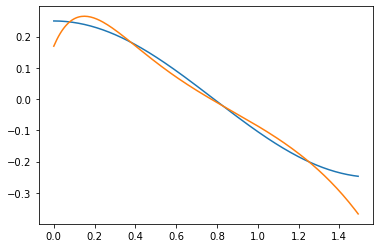

In [158]:
ntvec = 200
tvec = dt*jnp.arange(ntvec-1)
mylaguerre = [jnp.ones(ntvec-1), jnp.ones(ntvec-1)-tvec]
for k in range(1, ncoef-1):
    nextlaguerre = ((2*k + 1 - tvec)*mylaguerre[k] - k*mylaguerre[k-1])/(k+1)
    mylaguerre.append(nextlaguerre)

mylaguerre = jnp.array(mylaguerre)
myh12 = (theta[:ncoef] + 1j*theta[ncoef:]) @ mylaguerre

fintime = 200
plt.plot(tvec[:fintime], jnp.real(v/2*jnp.exp(1j*omega*tvec))[:fintime])
plt.plot(tvec[:fintime], jnp.real(myh12)[:fintime])
plt.show()

In [147]:
# theta consists of Laguerre polynomial coefficients
def mypred(theta):
    thetaR = theta[:ncoef]
    thetaI = theta[ncoef:]
    # times at which we want to evaluate Laguerre polynomials
    tvec = dt*jnp.arange(ntvec-1)
    laguerre = [jnp.ones(ntvec-1), jnp.ones(ntvec-1)-tvec]
    for k in range(1, ncoef-1):
        nextlaguerre = ((2*k + 1 - tvec)*laguerre[k] - k*laguerre[k-1])/(k+1)
        laguerre.append(nextlaguerre)
    
    laguerre = jnp.array(laguerre)
    allh12 = (thetaR + 1j*thetaI) @ laguerre
    mysol = jnp.concatenate([jnp.expand_dims(psi0,0), jnp.zeros((ntvec-1, 2), dtype=jnp.complex128)])
    def onestep(j, loopsol):
        modelham = jnp.array([[e1, allh12[j]],[jnp.conj(allh12[j]), e2]])
        spectrum, states = jnl.eigh(modelham)
        nextsol = states @ jnp.diag(jnp.exp(-1j*dt*spectrum)) @ states.conj().T @ loopsol[j]
        return loopsol.at[j+1].set(nextsol)
    
    mysol = jax.lax.fori_loop(0, ntvec-1, onestep, mysol)
    return mysol

In [148]:
test = mypred(theta)

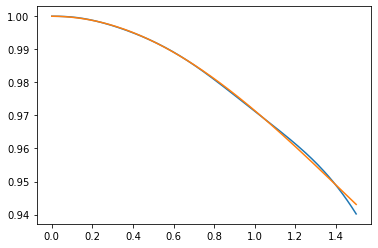

In [149]:
plt.plot(dt*jnp.arange(ntvec),jnp.abs(test)[:,0])
plt.plot(dt*jnp.arange(ntvec),jnp.abs(psit)[:,0])
plt.show()

In [166]:
jnp.mean(jnp.square(theta-truetheta))

DeviceArray(0.78007544, dtype=float64)